This notebook performs response-weighted analysis on the activation outputs of the Jaco model trained with domain randomisation.

# Initialisation

In [2]:
from rwa import * # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [3]:
# Define the network - returns the activation maps as outputs
class Network(nn.Module):
    def __init__(self, non_rgb_state_size, num_actions, hidden_size, init_weight_normal, visual_only=False):
        super(Network, self).__init__()
        # Define a flag
        self.visual_only = visual_only
        # Define the conv network
        self.conv1 = nn.Conv2d(3, 16, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2)
        if self.visual_only:
            self.fc1 = nn.Linear(1152, hidden_size)
        else:
            self.fc1 = nn.Linear(1152 + non_rgb_state_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        # define the network to output the policy
        self.fc_actor1 = nn.Linear(hidden_size, num_actions)
        self.fc_actor2 = nn.Linear(hidden_size, num_actions)
        self.fc_actor3 = nn.Linear(hidden_size, num_actions)
        self.fc_actor4 = nn.Linear(hidden_size, num_actions)
        self.fc_actor5 = nn.Linear(hidden_size, num_actions)
        self.fc_actor6 = nn.Linear(hidden_size, num_actions)
        # define the network to output the value
        self.critic_value = nn.Linear(hidden_size, 1)
        # orthogonal weight initialisation
        for name, p in self.named_parameters():
            if 'weight' in name:
                if init_weight_normal:
                    fan_in, _ = init._calculate_fan_in_and_fan_out(p)
                    std = 1 / math.sqrt(fan_in)
                    init.normal_(p, std=std)
                else:
                    init.orthogonal_(p)
            elif 'bias' in name:
                init.constant_(p, 0)
    
    # define the forward function
    def forward(self, non_rgb_state, rgb_state, h, masks, nenv=None):
        x1 = self.conv1(rgb_state / 255.0)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = x.view(x.size(0), -1)
        if self.visual_only:
            x = self.fc1(x)
        else:
            x = self.fc1(torch.cat((x, non_rgb_state), 1))
        if nenv is None:
            hx, cx = h
            hx = hx * masks
            cx = cx * masks
            h = self.lstm(x, (hx, cx))
            x = h[0]
        else:
            hxs, cxs = h
            envstartidx = np.arange(0, rgb_state.size(0), rgb_state.size(0) / nenv)
            x = x.view(-1, 1, x.size(1))
            masks = masks.view(-1, 1, masks.size(1))
            outputs = []
            for idx in range(rgb_state.size(0)):
                if idx in envstartidx:
                    hx = hxs[idx].unsqueeze(0)
                    cx = cxs[idx].unsqueeze(0)
                hx = hx * masks[idx]
                cx = cx * masks[idx]
                hx, cx = self.lstm(x[idx], (hx, cx))
                outputs.append(hx)
            x = torch.cat(outputs, 0)
            
        # get the alpha and beta for the beta distribution; the policy is *stochastic*
        policy1 = F.softmax(self.fc_actor1(x), dim=1).clamp(max=1 - 1e-20)
        policy2 = F.softmax(self.fc_actor2(x), dim=1).clamp(max=1 - 1e-20)
        policy3 = F.softmax(self.fc_actor3(x), dim=1).clamp(max=1 - 1e-20)
        policy4 = F.softmax(self.fc_actor4(x), dim=1).clamp(max=1 - 1e-20)
        policy5 = F.softmax(self.fc_actor5(x), dim=1).clamp(max=1 - 1e-20)
        policy6 = F.softmax(self.fc_actor6(x), dim=1).clamp(max=1 - 1e-20) 
        pi = (policy1, policy2, policy3, policy4, policy5, policy6)
        # get the state value
        value = self.critic_value(x)

        return x1, x2, h 

In [4]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = Network(num_actions=5, non_rgb_state_size=0, hidden_size=128, init_weight_normal=1, visual_only=True)

# load trained model
model_filename = './model_data/jaco_model/visual_random/seed_5/model.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Weights Visualisation - Conv 1 only

Weights of Conv1 only - serve as a sanity check of the RWA method.

In [5]:
# information of the network
print(net)
print(net.state_dict().keys())

Network(
  (conv1): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (fc_actor1): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor2): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor3): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor4): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor5): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor6): Linear(in_features=128, out_features=5, bias=True)
  (critic_value): Linear(in_features=128, out_features=1, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'lstm.weight_ih', 'lstm.weight_hh', 'lstm.bias_ih', 'lstm.bias_hh', 'fc_actor1.weight', 'fc_actor1.bias', 'fc_actor2.weight', 'fc_actor2.bias', 'fc_actor3.weight', 'fc_actor3.bias', 'fc_actor4.weig

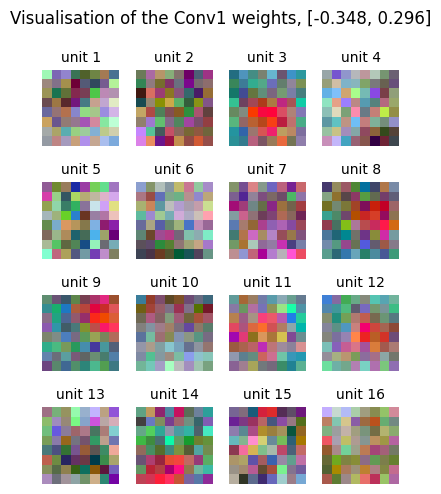

In [6]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=10)
plt.suptitle(f'Visualisation of the Conv1 weights, {[np.round(float(w1.min()), 3), np.round(float(w1.max()), 3)]}')
plt.tight_layout()
plt.gcf().set_size_inches(4, 5)
plt.show()

# Lab Recording Room

Where you collect neural responses

In [12]:
# experiment settings
batch_num = 50
batch_size = 1000
zero_mean = False
layer = 'conv1'

In [13]:
act_conv1, noise1 = JacoActRecorder(layer, net, batch_num=batch_num, batch_size=batch_size, zero_mean=zero_mean)
print(noise1.min(), noise1.max(), noise1.mean())

100%|██████████| 50/50 [00:05<00:00,  9.07it/s]


Activation recording completed


100%|██████████| 16/16 [00:00<00:00, 579.21it/s]


Shape of activation response list: torch.Size([16, 50000])
Shape of noise list: torch.Size([50000, 64, 64, 3])
tensor(0.) tensor(255.0000) tensor(127.4970)


In [15]:
# save the activation and noise data
torch.save(act_conv1, './rwa_data/jaco/jaco_rand/act1.pt')
torch.save(noise1, './rwa_data/jaco/jaco_rand/noise1.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

The noise input follows the requirements of STA - zero mean, symmetric noise distribution for unbiased estimation. \
However, it is important to note that the model never received negative inputs during training (since image data).

In [6]:
# load existing data if already recorded
batch_num = 50
batch_size = 1000
zero_mean = True
layer = 'conv1'

act_conv1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise1.pt')
rf1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf1.pt')
rf_corr1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')
correlation1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation1.pt')
rf_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')
noise_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1.pt')
# cov1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1.pt')
# cov1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1_.pt')
# rf_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1_.pt')
# noise_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1_.pt')

# # load eigen1.pkl
# with open('./rwa_data/jaco/jaco_rand_0mean/eigen1.pkl', 'rb') as f:
#     eigen1 = pickle.load(f)

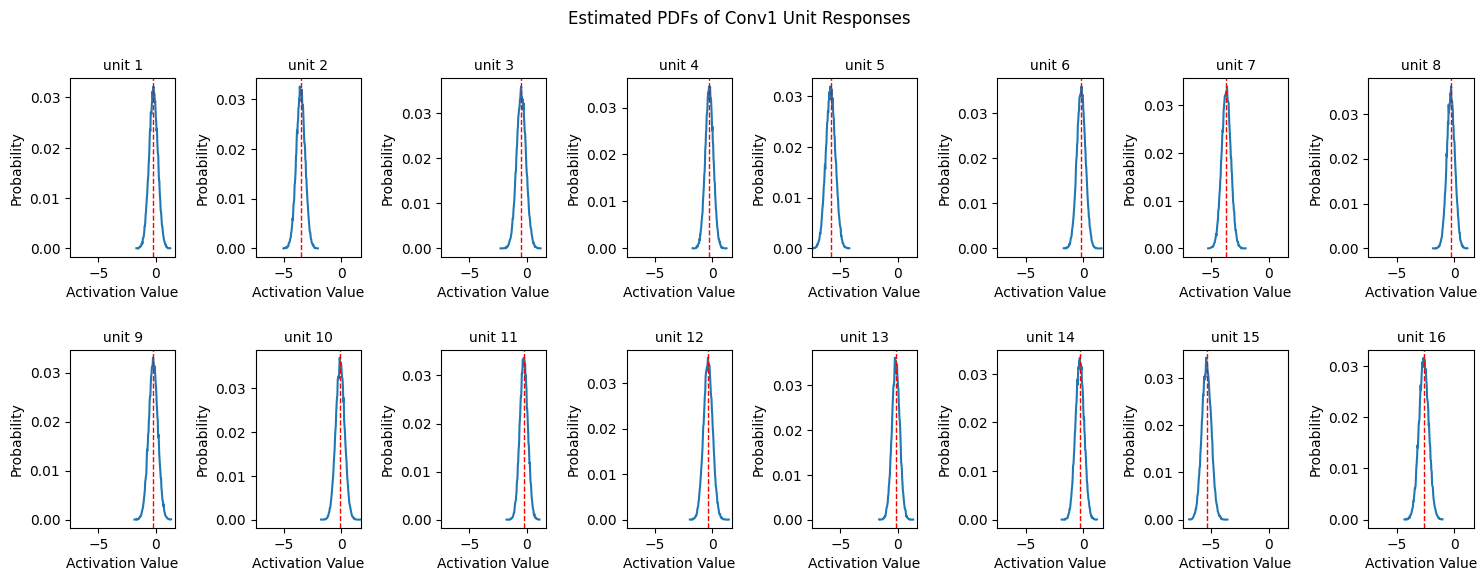

In [21]:
# PDFs of conv1 responses
# Gaussian because of CLT
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [38]:
# RWA - unbiased RF estimation
rf1 = RWA(act_conv1, noise1)

100%|██████████| 800000/800000 [01:43<00:00, 7741.00it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [39]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand_0mean/rf1.pt')

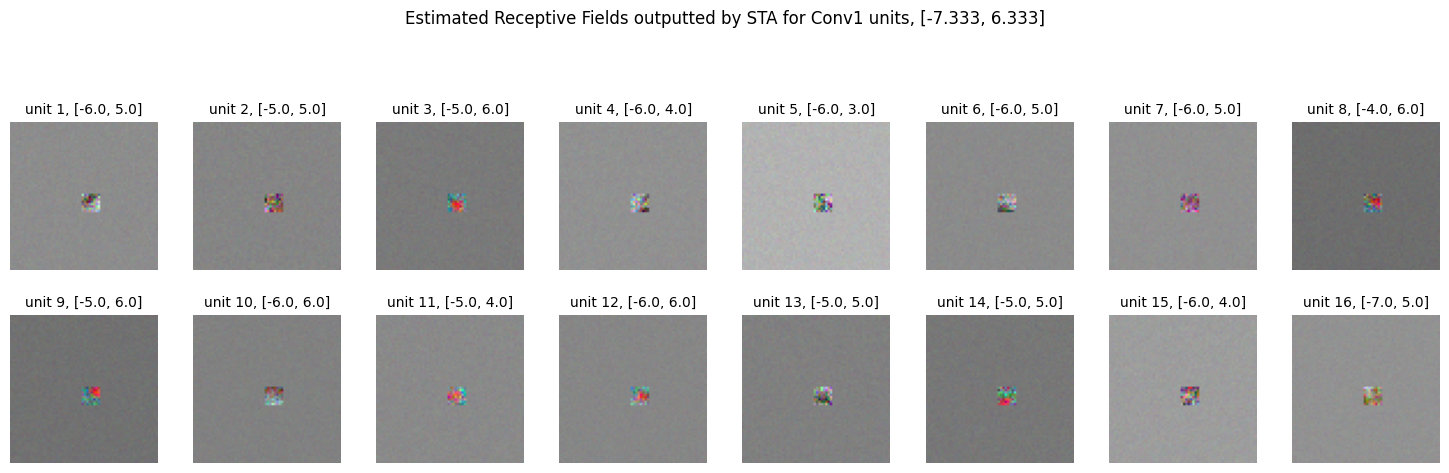

In [7]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}, [{np.round(rf1[i].min())}, {np.round(rf1[i].max())}]', fontsize=10)
    
# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by STA for Conv1 units, {[np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [6]:
# gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 65536/65536 [02:27<00:00, 445.25it/s]


In [17]:
# Save the RWA data
torch.save(rf_corr1, './rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')

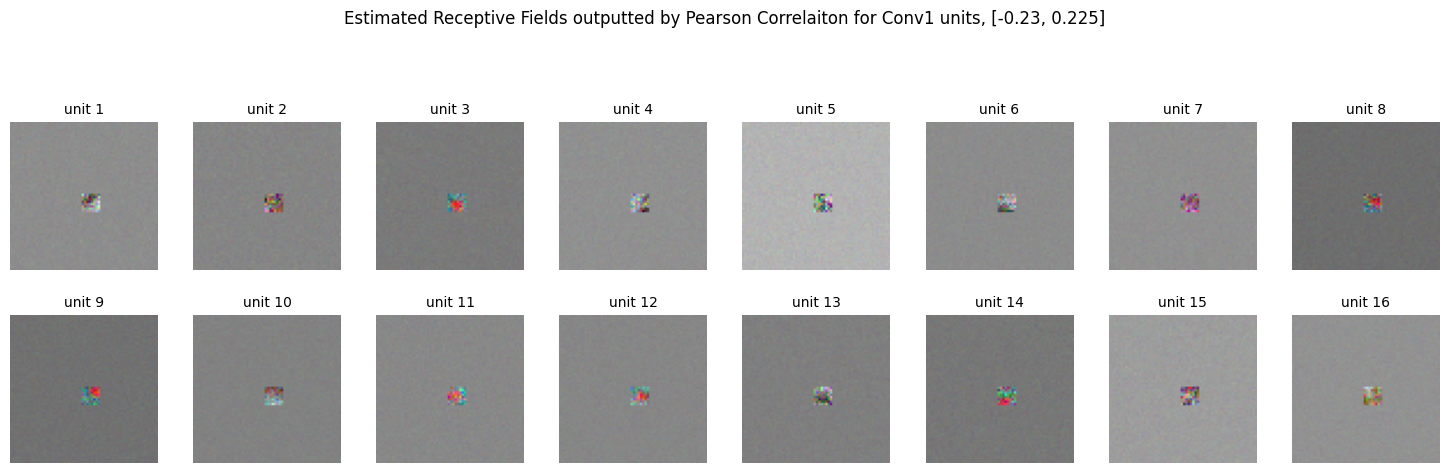

In [8]:
# Visualise the RWA output as image plots
for i in range(rf_corr1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=10)

# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by Pearson Correlaiton for Conv1 units, {[np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

RF Cropping via Pearson Correlation Mask

In [18]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrLoc(noise1[:, :, :, i], act_conv1)

100%|██████████| 65536/65536 [01:54<00:00, 570.47it/s]


In [22]:
# save the correlation data
torch.save(correlation1, './rwa_data/jaco/jaco_rand_0mean/correlation1.pt')

In [20]:
# crop the RFs
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, _ = RfCrop(correlation1[:, :, i], rf_corr1[:, :, :, i])
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

In [23]:
# save the cropped RFs
torch.save(rf_cropped1, './rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')

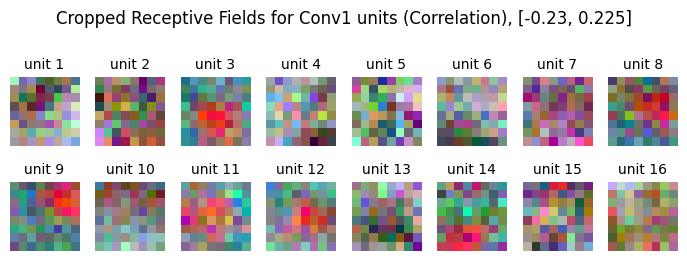

In [9]:
# display cropped RFs
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields for Conv1 units (Correlation), {[np.round(float(rf_cropped1.min()), 3), np.round(float(rf_cropped1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 3)
plt.show()

Response-Weighted Covariance

In [24]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [25]:
torch.save(noise_cropped1, './rwa_data/jaco/jaco_rand_0mean/noise_cropped1.pt')

In [12]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
mu = torch.zeros(rf.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

torch.Size([16, 50000, 192])


100%|██████████| 800000/800000 [02:30<00:00, 5311.05it/s]


torch.Size([16, 192, 192])


In [18]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 192])
Shape of cov1: torch.Size([16, 192, 192])


In [13]:
# save the pca covariance data
torch.save(cov1, './rwa_data/jaco/jaco_rand_0mean/cov1.pt')

In [41]:
# Principal Component Analysis
pca = PCA()
eigenvectors_max1 = [[] for i in range(cov1.shape[0])]
var_explained1 = [[] for i in range(cov1.shape[0])]
eigenvalues1 = [[] for i in range(cov1.shape[0])]

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    pca.fit(cov1[i])
    eigenvectors_max1[i] = pca.components_[0] # maximum eigenvector
    var_explained1[i] = pca.explained_variance_ratio_ # explained variances
    eigenvalues1[i] = pca.explained_variance_ # eigenvalues

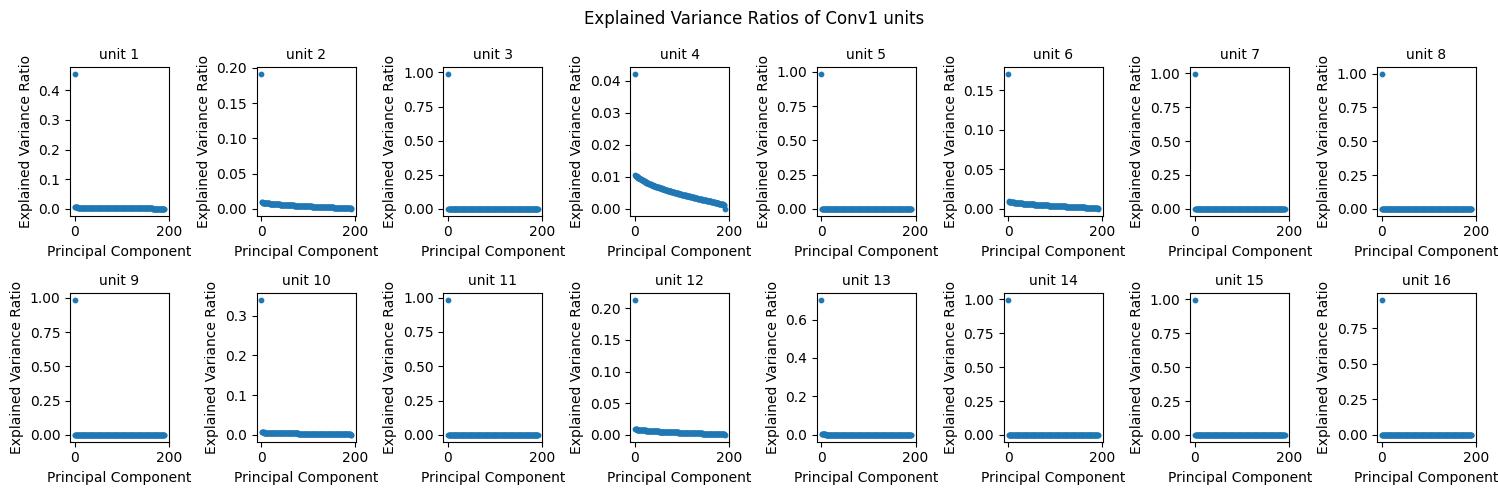

In [42]:
# visualise the eigenvalues
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.scatter(range(len(var_explained1[i])), var_explained1[i], s=10)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(15, 5)
plt.suptitle('Explained Variance Ratios of Conv1 units') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

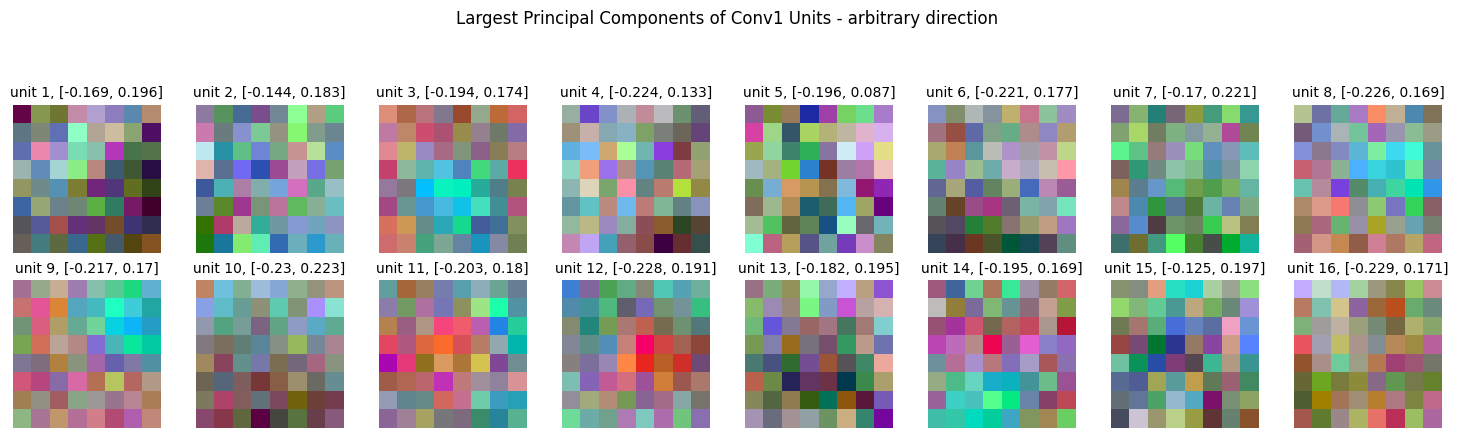

In [110]:
# Principal Components
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    x = eigenvectors_max1[i].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}, {[np.round(x.min(),3), np.round(x.max(),3)]}', fontsize=10)

plt.suptitle('Largest Principal Components of Conv1 Units - arbitrary direction') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

# Conv1 - Positive Only [0, 255]

In [7]:
# load existing data if already recorded
batch_num = 50
batch_size = 1000
zero_mean = False
layer = 'conv1'

act_conv1 = torch.load('./rwa_data/jaco/jaco_rand/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand/noise1.pt')
# rf1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf1.pt')
# rf_corr1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')
# correlation1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation1.pt')
# rf_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')
# noise_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1.pt')
# cov1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1.pt')
# cov1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1_.pt')
# rf_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1_.pt')
# noise_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1_.pt')

# # load eigen1.pkl
# with open('./rwa_data/jaco/jaco_rand_0mean/eigen1.pkl', 'rb') as f:
#     eigen1 = pickle.load(f)

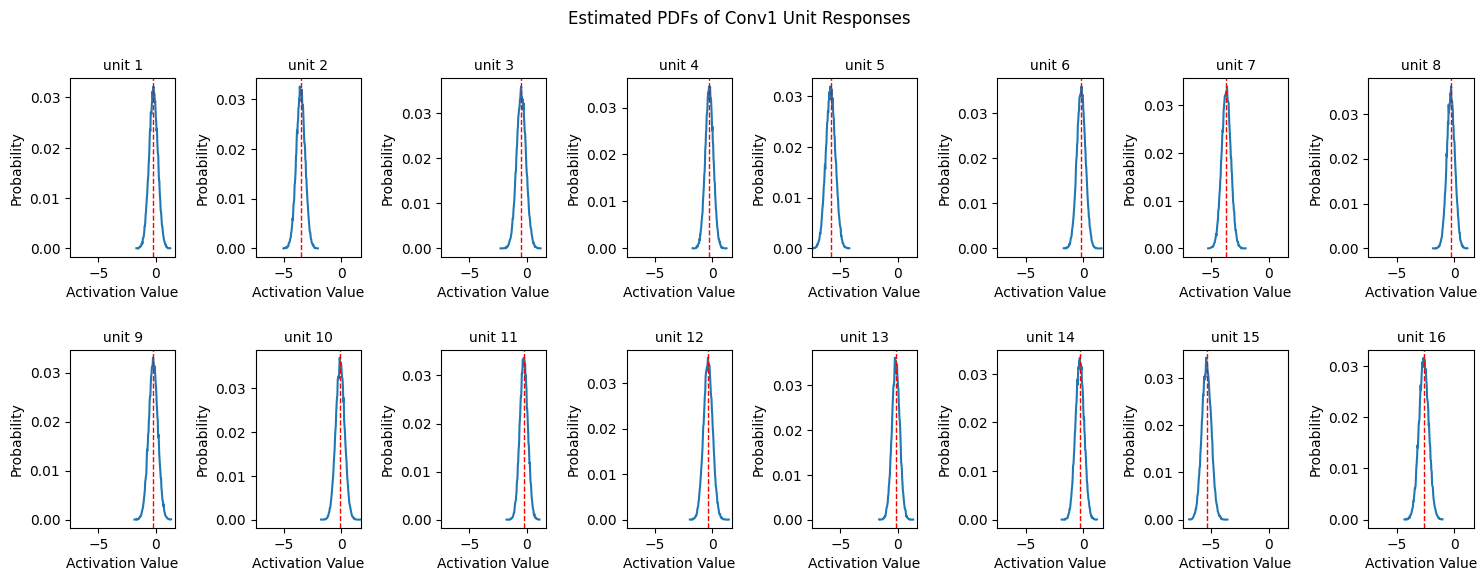

In [8]:
# PDFs of conv1 responses
# Gaussian because of CLT
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWA

In [9]:
# RWA - unbiased RF estimation
rf1 = RWA(act_conv1, noise1)

100%|██████████| 800000/800000 [01:14<00:00, 10716.79it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [10]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand/rf1.pt')

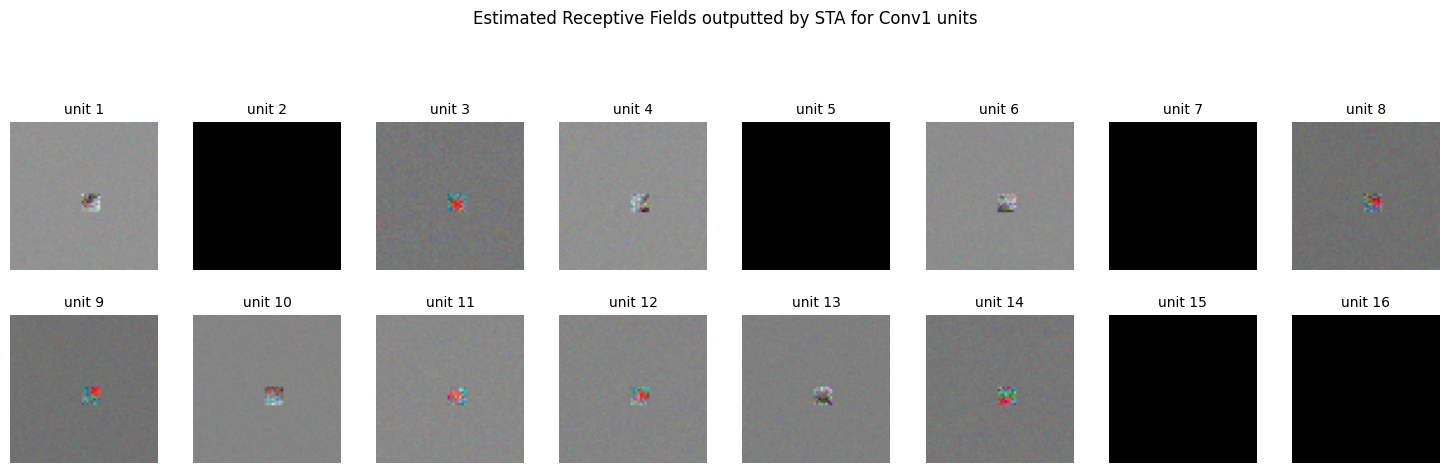

In [11]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf2.pt')
rf_corr2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')
correlation2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation2.pt')
rf_cropped2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')
noise_cropped2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped2.pt')
cov2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov2.pt')
cov2_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov2_.pt')

# load eigen1.pkl
with open('./rwa_data/jaco/jaco_rand_0mean/eigen2.pkl', 'rb') as f:
    eigen2 = pickle.load(f)

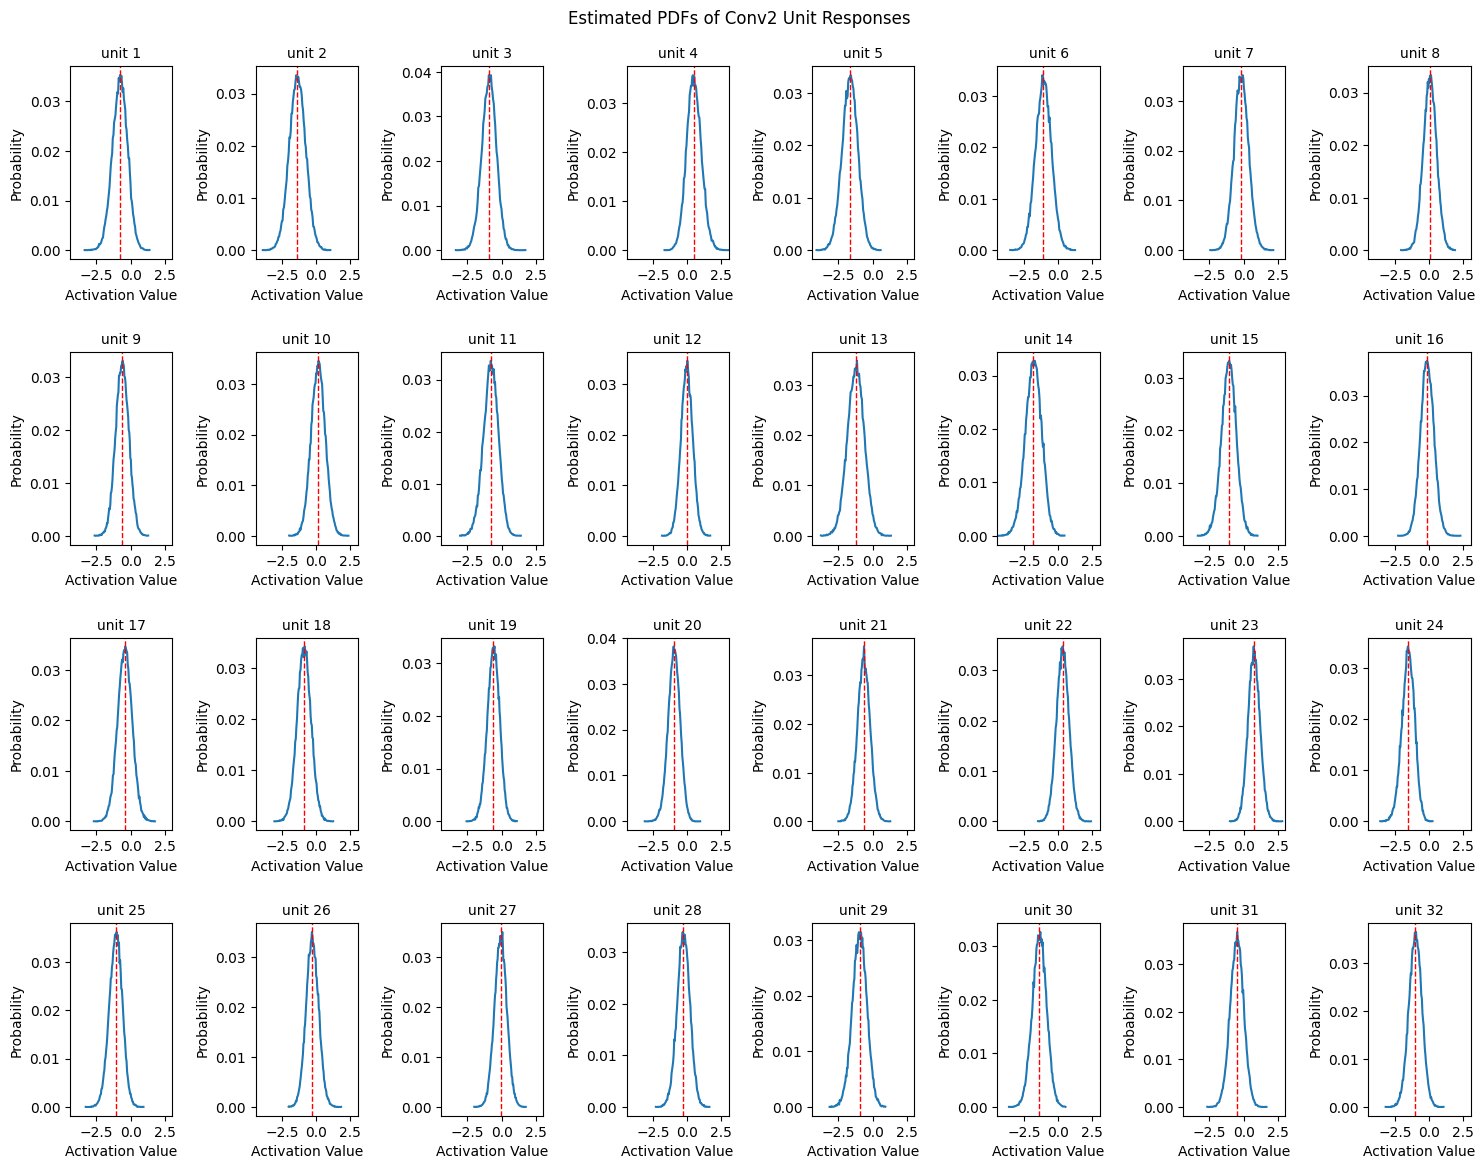

In [102]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    # plot initialisation
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    # plot the PDF of the activation values
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 12)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [103]:
# RWA
rf2 = RWA(act_conv2, noise2)

100%|██████████| 1600000/1600000 [02:30<00:00, 10642.17it/s]

Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [105]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand_0mean/rf2.pt')

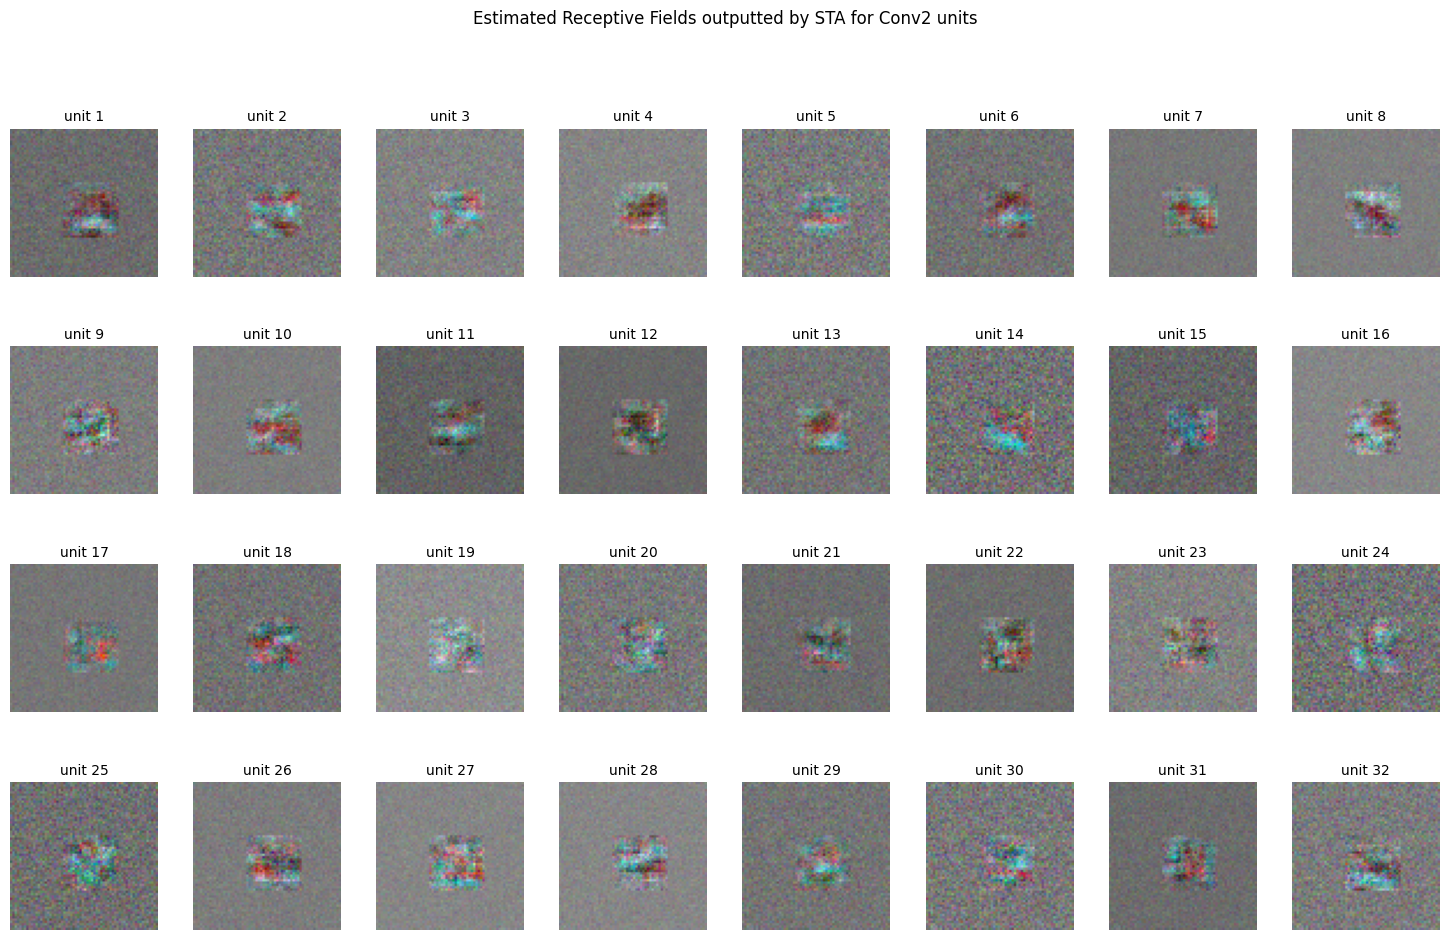

In [106]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [107]:
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]):
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

  0%|          | 0/131072 [00:00<?, ?it/s]

100%|██████████| 131072/131072 [03:54<00:00, 559.05it/s]


In [109]:
# Save the RWA data
torch.save(rf_corr2, './rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')

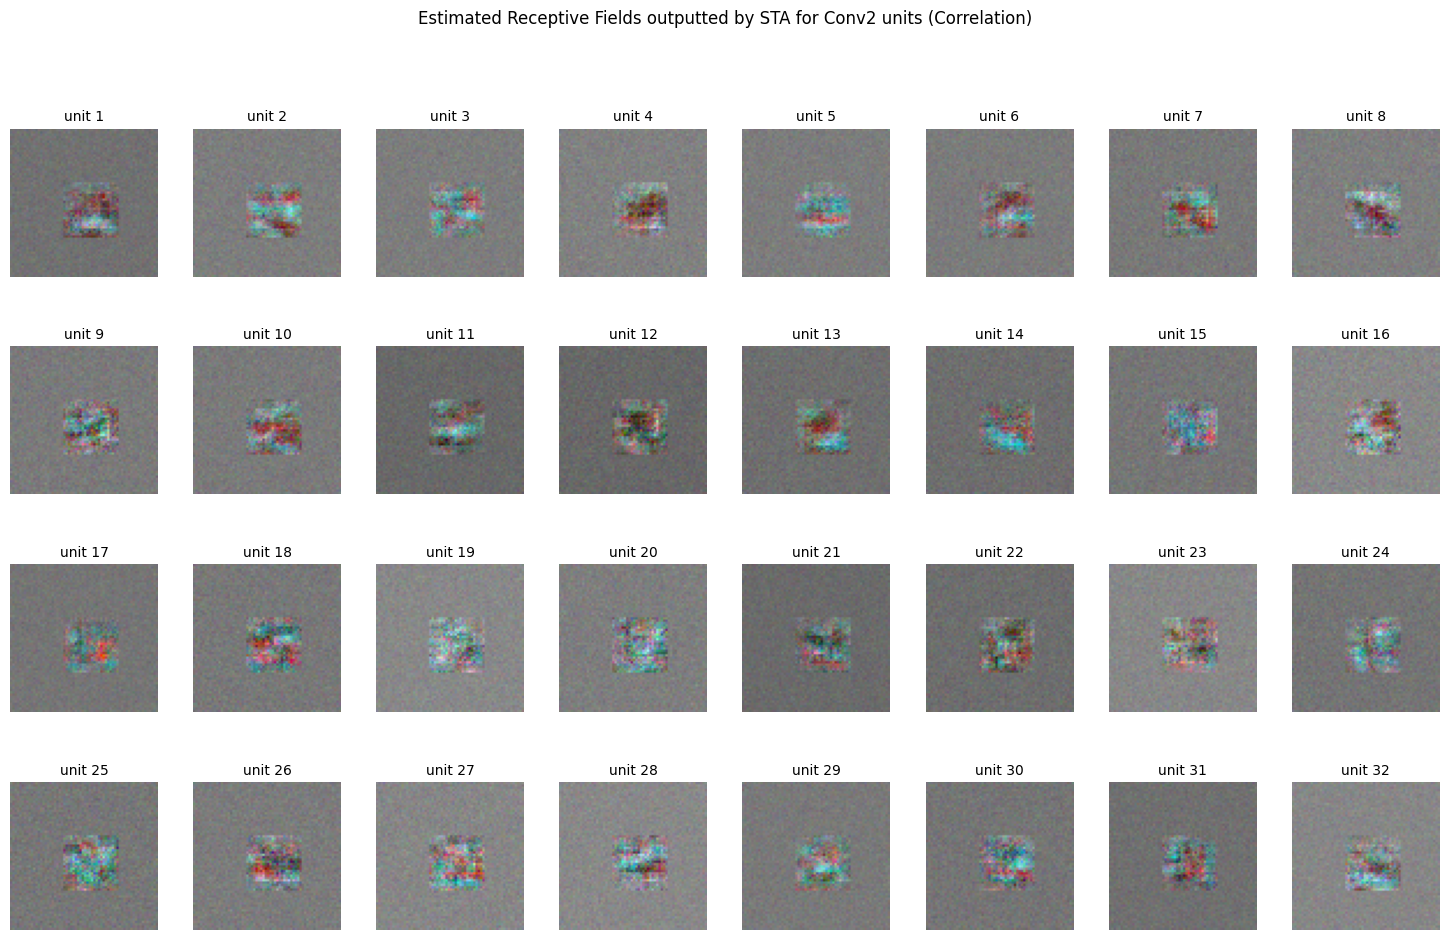

In [110]:
# Visualise the RWA output as image plots
for i in range(rf_corr2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Correlation

In [111]:
# calculate the Pearson correlation between the RFs and the input noise
correlation2 = torch.zeros(rf2.shape[1], rf2.shape[2], rf2.shape[3])
for i in range(rf2.shape[3]):
    correlation2[:, :, i] = CorrLoc(noise2[:, :, :, i], act_conv2)

100%|██████████| 131072/131072 [04:01<00:00, 542.70it/s]


In [112]:
# save the correlation data
torch.save(correlation2, './rwa_data/jaco/jaco_rand_0mean/correlation2.pt')

In [113]:
# crop the RFs
rf_cropped2 = []
for i in range(rf2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], rf2[:, :, :, i])
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

In [114]:
# save the cropped RFs
torch.save(rf_cropped2, './rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')

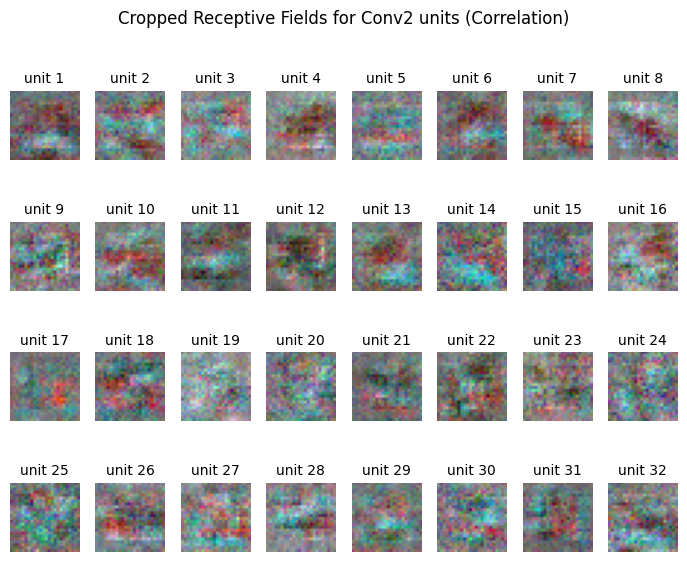

In [115]:
# display cropped RFs
for i in range(rf_cropped2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 6)
plt.show()

# Conv2 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand/rf2.pt')

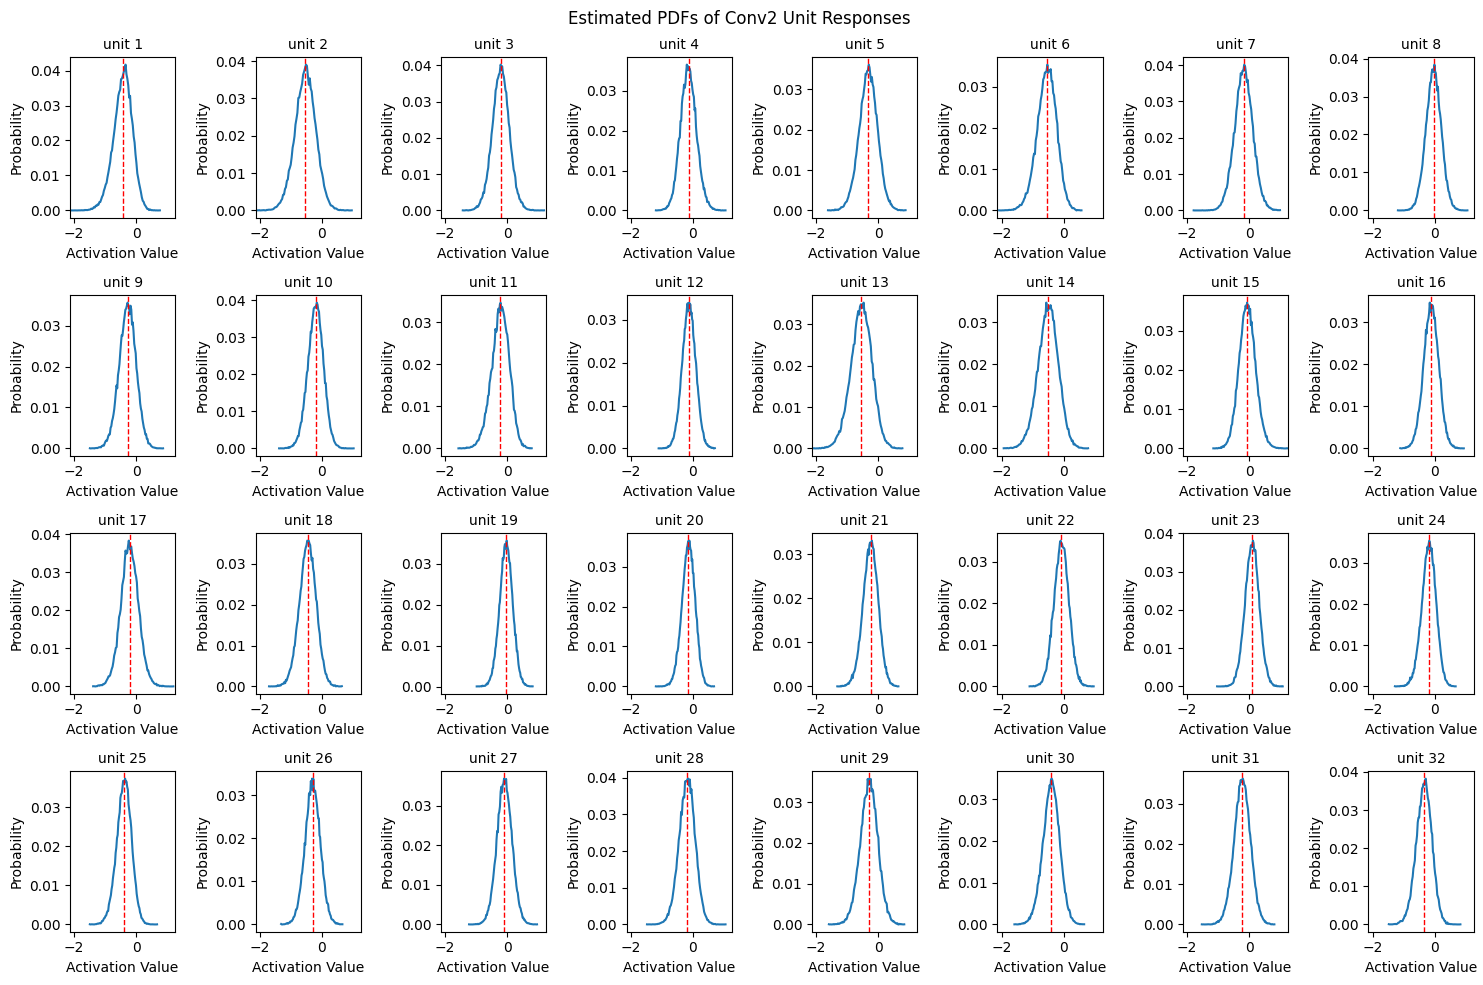

In [39]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

RWA

In [40]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, NBatches=NBatches, BSize=BSize)

100%|██████████| 1600000/1600000 [02:41<00:00, 9879.88it/s] 

Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [41]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand/rf2.pt')

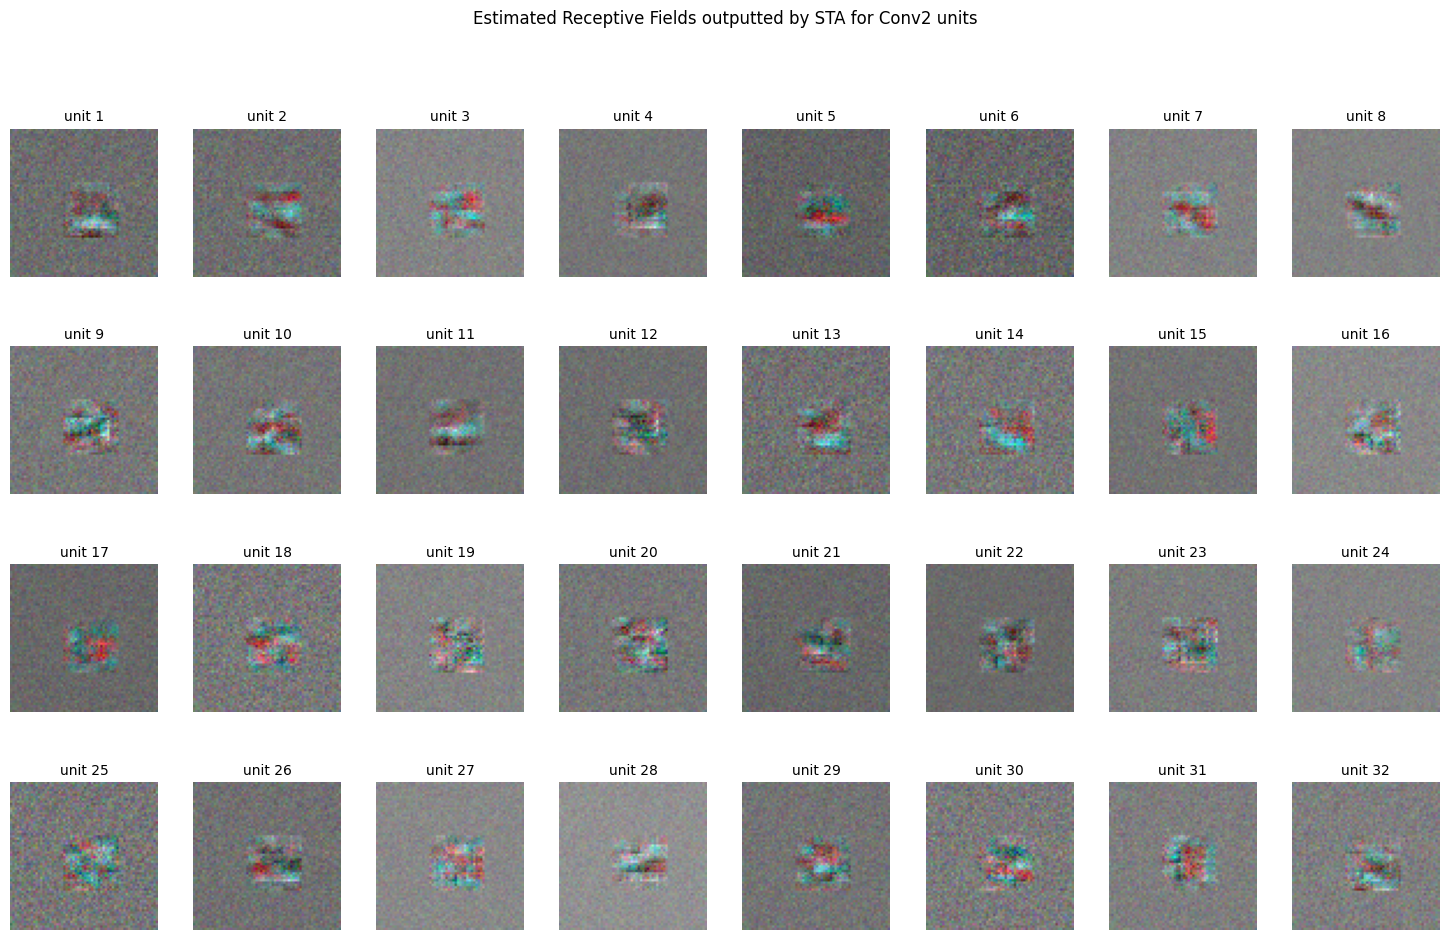

In [42]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()